<a href="https://colab.research.google.com/github/rahil551/Training-Transformers-From-scratch/blob/main/GPT_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
Gpt_config_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads": 12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False

 }

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.token_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    token_embeds = self.token_emb(in_idx)
    pos_emb = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = token_embeds + pos_emb
    x = self.drop_emb(x)
    x  = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x


class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps = 1e-5):
    super().__init__()


  def forward(self, x):
    return x

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


The output tensor has two rows corresponding to the two text samples. Each text sample
 consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of
 the tokenizer's vocabulary.

In [4]:
torch.manual_seed(123)
model = DummyGPTModel(Gpt_config_124M)
logits = model(batch)
print(logits.shape)
print(logits)

torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


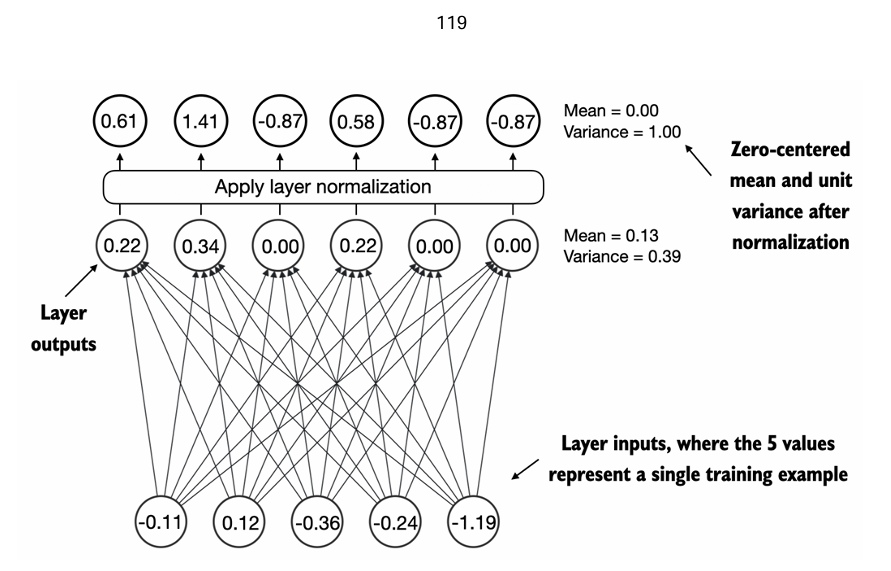

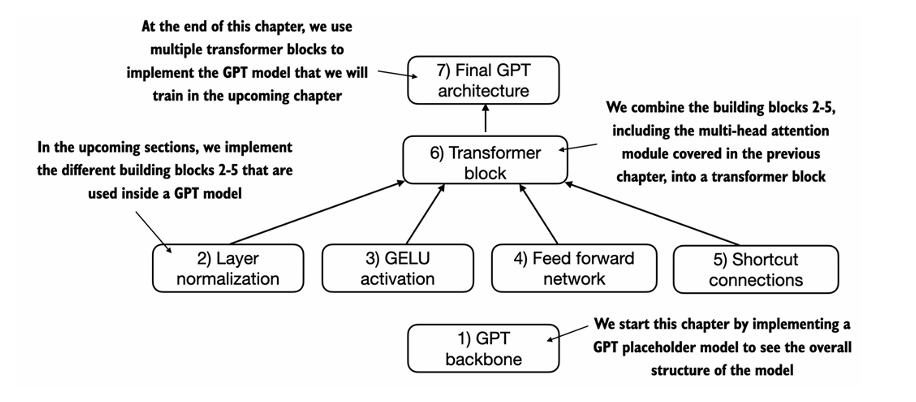

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim =1 , keepdims = True)
var = out.var(dim = 1, keepdim = True)
print(mean,var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>) tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
out_norm = (out-mean)/torch.sqrt(var)
mean - out_norm.mean(dim = 1, keepdim = True)
var = out_norm.var(dim = 1, keepdim =True)
print(out_norm)
print("Normalized Mean:", mean)
print("Var", var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Normalized Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    norm_x = (x-mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [9]:
torch.set_printoptions(sci_mode=False)
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, unbiased = False, keepdim = True)
print("Mean:" ,mean)
print("var", var)


Mean: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


 If you are familiar with batch normalization, a common and traditional normalization
 method for neural networks, you may wonder how it compares to layer
 normalization. Unlike batch normalization, which normalizes across the batch
 dimension, layer normalization normalizes across the feature dimension. LLMs often
 require significant computational resources, and the available hardware or the
 specific use case can dictate the batch size during training or inference. Since layer
 normalization normalizes each input independently of the batch size, it offers more
 flexibility and stability in these scenarios. This is particularly beneficial for distributed
 training or when deploying models in environments where resources are constrained.

In [10]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()


  def forward(self,x):
    return 0.5 * x *(1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))* (x + 0.044715 * torch.pow(x, 3))))


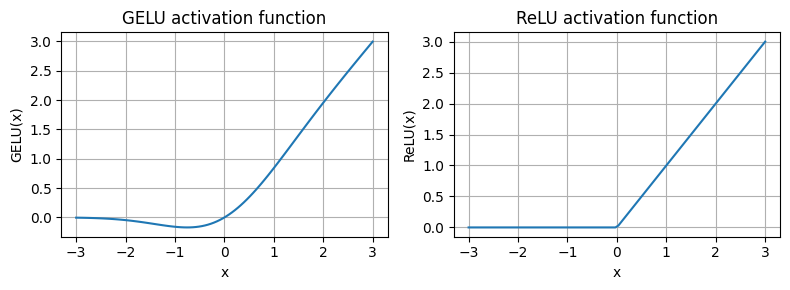

In [11]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)                                    #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
   plt.subplot(1, 2, i)
   plt.plot(x, y)
   plt.title(f"{label} activation function")
   plt.xlabel("x")
   plt.ylabel(f"{label}(x)")
   plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
class Feedforward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4* cfg["emb_dim"], cfg["emb_dim"]),
    )


  def forward(self, x):
    return self.layers(x)

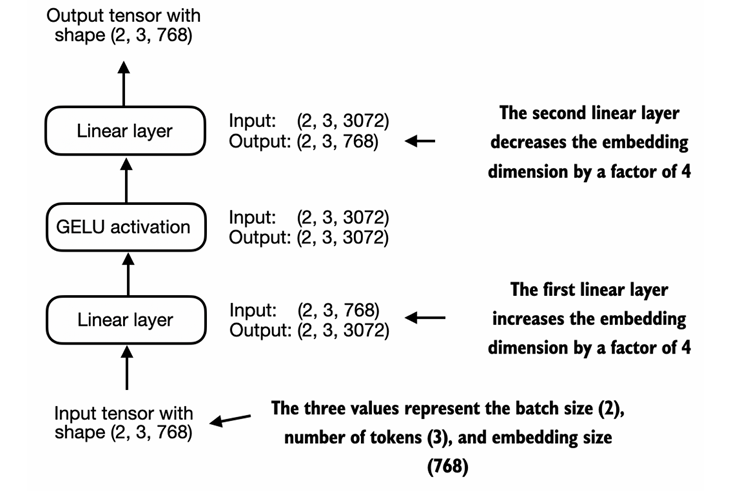

In [13]:
ffn = Feedforward(Gpt_config_124M)
x = torch.rand(2,3,768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


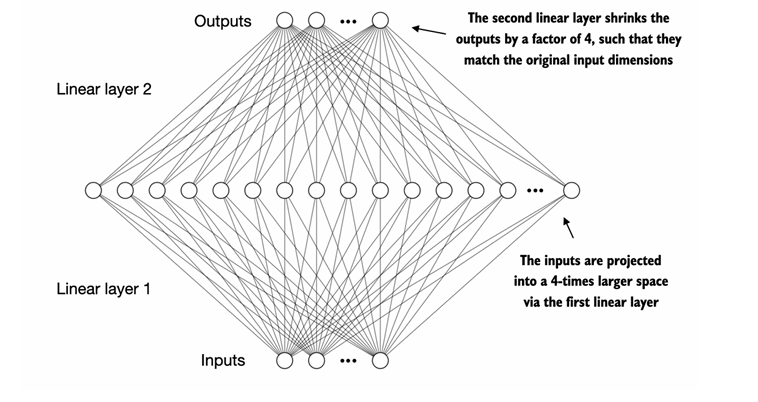

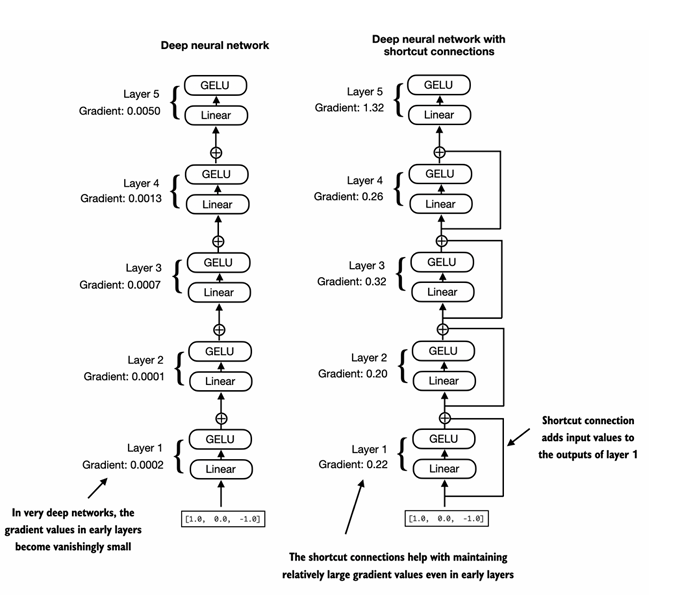

In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1], GELU())),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2], GELU())),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3], GELU())),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4], GELU())),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5], GELU()))
    ])

  def forward(self, x):
   for layer in self.layers:
    layer_output = layer(x)
    if self.use_shortcut and x.shape == layer_output.shape:
      x = x + layer_output
    else:
      x = layer_output
   return x

In [15]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([1.,0.,-1.])
torch.manual_seed(123)
model_without_Shortcut= ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = False)
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([0.])
  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()
  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [16]:
print(print_gradients(model_without_Shortcut, sample_input))

layers.0.0.weight has gradient mean of 0.001531339017674327
layers.1.0.weight has gradient mean of 0.0008734675939194858
layers.2.0.weight has gradient mean of 0.0021116069983690977
layers.3.0.weight has gradient mean of 0.0030934528913348913
layers.4.0.weight has gradient mean of 0.00788064580410719
None


In [17]:
torch.manual_seed(123)
model_with_shortcuts = ExampleDeepNeuralNetwork(layer_sizes , use_shortcut= True)
print(print_gradients(model_with_shortcuts, sample_input))

layers.0.0.weight has gradient mean of 0.2261722832918167
layers.1.0.weight has gradient mean of 0.5056600570678711
layers.2.0.weight has gradient mean of 0.30353114008903503
layers.3.0.weight has gradient mean of 0.454271525144577
layers.4.0.weight has gradient mean of 0.9717203974723816
None


In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)


        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)


        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)


        attn_scores = queries @ keys.transpose(2, 3)


        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]


        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)


        context_vec = (attn_weights @ values).transpose(1, 2)


        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec



In [19]:
class Transformerblock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length=  cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"])
    self.ff = Feedforward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])


  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.drop_shortcut(x)
    x = x + shortcut


    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x= self.drop_shortcut(x)
    x =  x + shortcut
    return x


In [20]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = Transformerblock(Gpt_config_124M)
output = block(x)
print(x.shape)
print(output.shape)

torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


In [144]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[Transformerblock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = nn.LayerNorm(cfg["emb_dim"], cfg["vocab_size"], bias = False)
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)
  def forward(self, idx):
    batch_size , seq_len = idx.shape
    tok_emb = self.tok_emb(idx)
    pos_emb = self.pos_emb(torch.arange(seq_len, device = idx.device))
    x= tok_emb + pos_emb
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x  = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [22]:
torch.manual_seed(123)
model = GPTModel(Gpt_config_124M)
out =  model(batch)
print(batch, out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]]) torch.Size([2, 4, 50257])
tensor([[[-0.0025,  0.0257,  0.0079,  ...,  0.0260, -0.0157, -0.0074],
         [ 0.0297, -0.0252, -0.0271,  ..., -0.0116,  0.0088,  0.0080],
         [ 0.0390, -0.0012, -0.0383,  ...,  0.0412, -0.0667, -0.0102],
         [-0.0473,  0.0269, -0.0226,  ...,  0.0589,  0.0064, -0.0247]],

        [[-0.0043, -0.0036,  0.0381,  ...,  0.0238, -0.0114, -0.0216],
         [ 0.0038,  0.0077, -0.0029,  ...,  0.0393, -0.0154,  0.0435],
         [ 0.0762,  0.0387, -0.0267,  ...,  0.0438, -0.0035, -0.0141],
         [ 0.0281,  0.0060,  0.0363,  ...,  0.0844, -0.0430, -0.0044]]],
       grad_fn=<UnsafeViewBackward0>)


In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

163008768


In [24]:
print("Token Embedding shape", model.tok_emb.weight.shape)
print("Output layer shape", model.out_head.weight.shape)

Token Embedding shape torch.Size([50257, 768])
Output layer shape torch.Size([50257, 768])


In [25]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(total_params_gpt2)

124411392


In [26]:
block = Transformerblock(Gpt_config_124M)
ffn_params = sum(p.numel() for p in block.ff.parameters())
print(ffn_params)

4722432


In [27]:
attention_params = sum(p.numel() for p in block.att.parameters())
print(attention_params)

2360064


In [28]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes/(1024 * 1024)
print(total_size_mb)

621.8291015625


In [29]:
print(total_size_bytes)

652035072


In [30]:
def get_config(base_config, model_name = 'gpt2-small'):
  get_config = base_config.copy()
  if model_name == "gpt2-small":
    get_config["emb_dim"] = 768
    get_config["n_layers"] = 12
    get_config["n_heads"] = 12

  elif model_name == "gpt2-medium":
     get_config["emb_dim"] = 1024
     get_config["n_layers"] = 24
     get_config["n_heads"] = 16


  elif model_name == "gpt2-large":
      get_config["emb_dim"] = 1280
      get_config["n_layers"] = 36
      get_config["n_heads"] = 20

  elif model_name == "gpt2-xl":
      get_config["emb_dim"] = 1600
      get_config["n_layers"] = 48
      get_config["n_heads"] = 25


  else:
    raise ValueError(f"Incorrect model name {model_name}")

  return get_config

def calculate_size(model):
  total_params = sum(p.numel() for p in model.parameters())
  total_params_gpt_2 = total_params - sum(p.numel() for p in model.out_head.parameters())
  print(total_params_gpt_2)

  total_size = total_params_gpt_2 * 4
  total_size_mb = total_size /(1024*1024)

  print(total_size_mb)

In [31]:
for model_abbrev in ("small", "medium", "large", "xl"):
  model_name = f"gpt2-{model_abbrev}"
  config = get_config(Gpt_config_124M, model_name = model_name)
  model = GPTModel(config)
  print(model_name)
  calculate_size(model)

gpt2-small
124411392
474.591796875
gpt2-medium
354748416
1353.2578125
gpt2-large
773890560
2952.158203125
gpt2-xl
1557379200
5940.93017578125


In [32]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [33]:
start_context = "Every"
encoded = tokenizer.encode(start_context)
print(encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(encoded_tensor.shape)

[6109]
torch.Size([1, 1])


In [35]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = Gpt_config_124M["context_length"]

)

print(out.shape)
print(out)

torch.Size([1, 7])
tensor([[ 6109, 32252, 13426, 42594, 33148, 27618,  2602]])


In [36]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Every Scy\\\\orbitaths pics________


In [37]:
GPT_config_124M = {
    "vocab_size": 50257,
    "context_length":256,
    "emb_dim": 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False}


torch.manual_seed(123)
model = GPTModel(GPT_config_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feedforward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transformerblock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [44]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_config_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you), mysticenment global secondaryized propagate microbiomeGWLeft


In [45]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [46]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=1) # Probability of each token in vocabulary
print(probas)

tensor([[[0.3371, 0.3289, 0.3374,  ..., 0.3285, 0.3252, 0.3374],
         [0.3167, 0.3326, 0.3196,  ..., 0.3394, 0.3230, 0.3289],
         [0.3463, 0.3385, 0.3429,  ..., 0.3321, 0.3517, 0.3337]],

        [[0.3384, 0.3274, 0.3377,  ..., 0.3347, 0.3427, 0.3326],
         [0.3160, 0.3276, 0.3134,  ..., 0.3460, 0.3089, 0.3333],
         [0.3456, 0.3450, 0.3489,  ..., 0.3193, 0.3484, 0.3341]]])


In [47]:
token_ids = torch.argmax(probas, dim = -1, keepdim = True)
print(token_ids)

tensor([[[28581],
         [16031],
         [37024]],

        [[ 5796],
         [19871],
         [18301]]])


In [48]:
print(f"Targets Batch 1{token_ids_to_text(targets[0],  tokenizer)}")
print(f"Output batch 1{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets Batch 1 effort moves you
Output batch 1 182 saves Comed


In [49]:
test_idx = 0
target_prob_1 = probas[test_idx, [0,1,2], targets[test_idx]]
print(target_prob_1)
test_idx = 1
target_prob_2 = probas[test_idx, [0,1,2], targets[test_idx]]
print(target_prob_2)

tensor([0.3402, 0.3414, 0.3234])
tensor([0.3274, 0.3401, 0.3146])


In [50]:
log_probas = torch.log(torch.cat((target_prob_1, target_prob_2)))
print(log_probas)

tensor([-1.0783, -1.0746, -1.1287, -1.1165, -1.0785, -1.1564])


In [51]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-1.1055)


In [52]:
neg_log_probas = avg_log_probas * -1
print(neg_log_probas)

tensor(1.1055)


In [53]:
print(logits.shape)
print(targets.shape)

torch.Size([2, 3, 50257])
torch.Size([2, 3])


In [54]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [55]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8195)


In [56]:
per_loss = torch.exp(loss)
print(per_loss)

tensor(49985.7539)


In [57]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
  url = (("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt"))
  file_path = "the-verdict.txt"
  urllib.request.urlretrieve(url , file_path)

In [58]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding = "utf-8") as file:
  text_data = file.read()

In [59]:
print(len(text_data))
total_tokens = len(tokenizer.encode(text_data))
print(total_tokens)

20479
5145


In [60]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [61]:
from torch.utils.data import Dataset, DataLoader
import torch
class GPTDatasetv1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
    assert len(token_ids) > max_length , "No of tokenizer input Must be less than max_length"


    for i in range(0, len(token_ids) - max_length, stride):
      input = token_ids[i : i+max_length]
      target = token_ids[i+1: i+ max_length  + 1]
      self.input_ids.append(torch.tensor(input))
      self.target_ids.append(torch.tensor(target))


  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]

In [62]:
def create_dataloader(txt, batch_size = 4, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_works = 0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetv1(txt , tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size= batch_size,
      shuffle= shuffle,
      drop_last = drop_last,
      num_workers = num_works
  )
  return dataloader


In [63]:
train_loader = create_dataloader(

    train_data,
    batch_size= 2,
    max_length = GPT_config_124M["context_length"],
    stride = GPT_config_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_works = 0
)
val_loader = create_dataloader(

    val_data,
    batch_size= 2,
    max_length = GPT_config_124M["context_length"],
    stride = GPT_config_124M["context_length"],
    drop_last = False,
    shuffle = False,
    num_works = 0
)

In [64]:
len(val_data)

2048

In [65]:
print("Train Loder")
for x, y in train_loader:
  print(x.shape,y.shape)


Train Loder
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [66]:
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens += input_batch.numel()
print(train_tokens)
val_tokens = 0
for input_batch , target_batch in val_loader:
  val_tokens += input_batch.numel()
print(val_tokens)

4608
512


In [67]:
# def cal_loss(input_batch, target_batch, model, device):
#   input_batch , target_batch = input_batch.to(device), target_batch.to(device)
#   logits = model(input_batch)
#   loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
#   return loss

In [68]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss  = calc_loss_loader(val_loader, model, device)
print(train_loss)
print(val_loss)

10.825737211439344
10.82502269744873


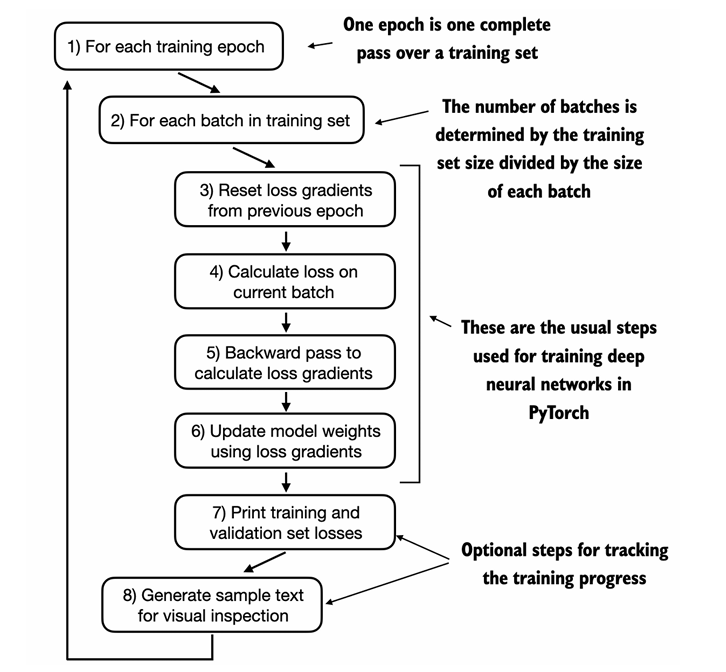

In [70]:
# def evaluate_model(model, train_loader,val_loader, device, eval_iter):
#   model.eval()
#   with torch.no_grad():
#     train_loss = calc_loss_loader(train_loader,model, device,num_batches = eval_iter)
#     val_loss = calc_loss_loader(val_loader, model, device, num_batches= eval_iter)
#   model.train()
#   return train_loss, val_loss



In [71]:
# def generate_and_print_sample(model, tokenizer, device, start_context):
#    model.eval()
#    context_size = model.pos_emb.weight.shape[0]
#    encoded = text_to_token_ids(start_context, tokenizer).to(device)
#    with torch.no_grad():
#        token_ids = generate_text(
#            model=model, idx=encoded,
#            max_new_tokens=50, context_size=context_size
#        )
#    decoded_text = token_ids_to_text(token_ids, tokenizer)
#    print(decoded_text.replace("\n", " "))  # Compact print format
#    model.train()

In [72]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


In [73]:
torch.manual_seed(123)
model = GPTModel(GPT_config_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)
num_epochs = 100
train_losses, val_losses, token_seen = train_model_simple(model , train_loader, val_loader, optimizer, device, num_epochs= num_epochs, eval_freq = 5, eval_iter = 5, start_context = "Every effort Moves you", tokenizer = tokenizer)



Ep 1 (Step 000000): Train loss 10.806, Val loss 10.807
Ep 1 (Step 000005): Train loss 10.517, Val loss 10.551
Every effort Moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 8.476, Val loss 8.655
Ep 2 (Step 000015): Train loss 6.620, Val loss 6.988
Every effort Moves you                                                  
Ep 3 (Step 000020): Train loss 6.314, Val loss 6.745
Ep 3 (Step 000025): Train loss 6.156, Val loss 6.796
Every effort Moves you a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
Ep 4 (Step 000030): Train loss 6.075, Val loss 6.833
Ep 4 (Step 000035): Train loss 6.059, Val loss 6.900
Every effort Moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000040): Train loss 6.014, Val loss 6.944
Every effort Moves you,                                                 
Ep 6 (Step 000045): Train loss 6.016, Val loss 6.944
Ep 6 (Step 000050): Train loss 6.021, Val loss 6.95

In [75]:
model.to("cpu")
model.eval()
tokenizer   = tiktoken.get_encoding("gpt2")
token_ids  = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens = 25,
    context_size = GPT_config_124M["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you was for a little more--as.




"I felt that he was one of a little work of


In [76]:
vocab = {
    "closer":0,
    "every" :1,
    "effort" :2,
    "forward" :3,
    "inches":4,
    "moves":5,
    "pizza":6,
    "toward":7,
    "you":8
}
inverse_vocab = {v:k for k,v in vocab.items()}

In [77]:
next_token_logits = torch.tensor(
   [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
 )

In [78]:
prob = torch.softmax(next_token_logits, dim = 0)
next_token_id =  torch.argmax(prob).item()
print(inverse_vocab[next_token_id])

forward


In [79]:
torch.manual_seed(123)
next_token_ids  = torch.multinomial(prob, num_samples = 1).item()
print(inverse_vocab[next_token_ids])

forward


In [81]:
def print_sample_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(prob, num_samples = 1).item() for i in range(1_000)]
  sample_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sample_ids):
    print(f"{freq} x {inverse_vocab[i]}")

print(print_sample_tokens(prob))

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
None


In [82]:
def softmax_with_temp(logits, temperature):
  scaled_logits = logits/temperature
  return torch.softmax(scaled_logits, dim = 0)


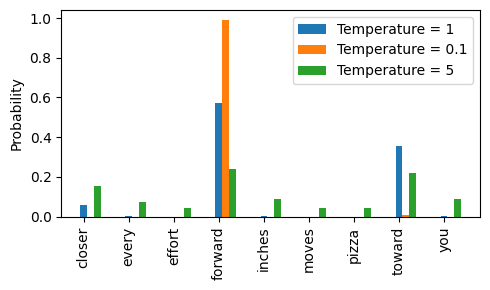

In [83]:
temperatures= [1,0.1, 5]
scaled_prob = [softmax_with_temp(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
   rects = ax.bar(x + i * bar_width, scaled_prob[i],
                  bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


In [84]:
for i, probas in enumerate(scaled_prob):
    print("\n\nTemperature:", temperatures[i])
    print_sample_tokens(probas)



Temperature: 1
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


Temperature: 0.1
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


Temperature: 5
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [85]:
temp = 2
pizza_idx = 6
scaled_prob[temp][pizza_idx]

tensor(0.0430)

Top-K sampling


In [86]:
top_k = 3
top_logits , top_pos = torch.topk(next_token_logits, top_k)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [87]:
new_logits = torch.where(
   condition=next_token_logits < top_logits[-1],                 #A
   input=torch.tensor(float('-inf')),                          #B
   other=next_token_logits                                       #C
 )
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [88]:
top_k_prob = torch.softmax(new_logits, dim = 0)
print(top_k_prob)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Generate Text with top_k and Tempearture Scaling


In [89]:
def generate_text(model, idx, max_new_tokens, context_size,temperature = 0.1, top_k = None,  eos_id = None):
  for _ in range(max_new_tokens):
    idx_count = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_count)
    logits = logits[:,-1, :]
    if top_k is None:
      top_logits , _ = torch.topk(logits, top_k)
      min_val = top_logits[:,-1]
      logits = torch.where(logits < min_val,
                           torch.tensor(float('-inf')).to(logits.device),
                           logits)
    if temperature > 0.0:
      logits  = logits/temperature
      probas = torch.softmax(logits, dim = -1)
      idx_next = torch.multinomial(probas, num_samples = 1)
      idx = torch.cat((idx, idx_next), dim = 1)

    else: idx_next = torch.argmax(logits, dim = -1, keepidm = True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim = 1)
  return idx


In [94]:
torch.manual_seed(123)
token_ids = generate_text(model , idx = text_to_token_ids("Every effort moves you", tokenizer),
                          max_new_tokens = 15,
                          context_size = GPT_config_124M["context_length"],
                          top_k = 25,
                          temperature = 1.4)
print("output text", token_ids_to_text(token_ids, tokenizer))


output text Every effort moves you was was what what Mrs Mrs.. And And you you forehead forehead close close drew drew at at my my portrait portrait would would st st by by


In [90]:
torch.save(model.state_dict(), "model.pth")

In [95]:
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_sate_dict" : optimizer.state_dict(),

},
  "model_and_optimizer.pth"
)

In [ ]:
# checkpoint = torch.load("model_and_optimizer.pth")
# model = GPT_config_124M(GPT_config_124M)
# model.laod_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr = 0.004, weight_decay = 0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train()

In [96]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
 )
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7c893a949d60>)

In [97]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size= "124M", models_dir = "gpt2")


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 156kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.40MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 176kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:18<00:00, 3.60MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.80MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.53MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.95MiB/s]


In [98]:
print(settings, params.keys())

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12} dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [99]:
print(params['wte'].shape)

(50257, 768)


In [126]:
model_configs = {
    "gpt2-small (124M)":{"emb_dim" : 768, "n_layers" : 12, "n_heads" : 12},
    "gpt2-medium (355M)":{"emb_dim" : 1024, "n_layers" : 24, "n_heads" : 16},
    "gpt2-large(774M)":{"emb_dim" : 1280, "n_layers" : 36, "n_heads" :20},
    "gpt2-xl(1558M)":{"emb_dim" : 1600, "n_layers" : 48, "n_heads" : 25},
}
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_config_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})

In [125]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 1024,
 'n_heads': 16,
 'n_layers': 24,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [127]:
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): Transformerblock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): Feedforward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transformerblock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [107]:
def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f"Shape Mismatch: Left{left.shape}, Right:{right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [145]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

AttributeError: 'LayerNorm' object has no attribute 'scale'

In [146]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

AttributeError: 'LayerNorm' object has no attribute 'scale'

In [148]:
torch.manual_seed(123)
token_ids = generate_text(
   model=gpt,
   idx=text_to_token_ids("Every effort moves you", tokenizer),
   max_new_tokens=25,
   context_size=NEW_CONFIG["context_length"],
   top_k=50,
   temperature=1.5
 )
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

RuntimeError: Expected all tensors to be on the same device, but got weight is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA__native_layer_norm)